<a href="https://colab.research.google.com/github/DavinciB/child_grooming_detector/blob/main/Comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
import xml.etree.ElementTree as ET
from matplotlib import pyplot as plt
import csv


def get_labels_dict(data_path):
    labels_dict = {}
    with open(data_path + 'sci_labels.csv', 'r') as f:
        file = csv.reader(f)
        for row in file:
            labels_dict[row[0]] = row[1]
    return labels_dict

def get_features_labels(root, labels_dict):
    corpus = []
    labels = []
    for conversation in root:
        string = " "
        for message in conversation:
            text = message.find('text').text
            if text is not None:
                string = string + "\r\n" + text
        corpus.append(string)
        labels.append(int(labels_dict[conversation.get('id')]))
    return corpus, labels
train_data_path = '/content/drive/MyDrive/online-grooming-detector-master/data/svm_training_data/'
training_xml = ET.parse(train_data_path + 'training_data.xml')
train_root = training_xml.getroot()
test_data_path = '/content/drive/MyDrive/online-grooming-detector-master/data/svm_test_data/'
test_data_src = '/content/drive/MyDrive/online-grooming-detector-master/data/pan12-sexual-predator-identification-test-corpus-2012-05-21/'
test_xml = ET.parse(test_data_src + 'pan12-sexual-predator-identification-test-corpus-2012-05-17.xml')
test_root = test_xml.getroot()
train_corpus, train_labels = get_features_labels(train_root, get_labels_dict(train_data_path))
test_corpus, test_labels = get_features_labels(test_root, get_labels_dict(test_data_path))

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy
import numpy as np

vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train_corpus)
X_test = vectorizer.transform(test_corpus)
X_train = scipy.sparse.csr_matrix(X_train)
y_train = np.array(train_labels)
X_test = scipy.sparse.csr_matrix(X_test)
y_test = np.array(test_labels)

In [9]:
from sklearn import svm
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn import metrics
import heapq
import operator
import numpy as np
from sklearn.svm import LinearSVC

'''num_fold = 10
k_fold = KFold(num_fold, True, 1)
acc = []

for coef_c in np.arange(0.1, 5.1, 0.1):
    acc_arr = np.zeros(num_fold)
    ind = 0
    for train_rows, val_rows in k_fold.split(X_train):
        model = LinearSVC(random_state=0, C=coef_c, loss='squared_hinge', dual=True)
        model.fit(X_train[train_rows], y_train[train_rows])
        pred_y = model.predict(X_train[val_rows])
        acc_arr[ind] = metrics.accuracy_score(y_train[val_rows], pred_y)
        ind += 1
    acc.append([coef_c, np.mean(acc_arr)])
    print("c={}, Accuracy: {}".format(coef_c, acc[len(acc)-1][1]))
plt.plot([i[0] for i in acc], [i[1] for i in acc])
plt.title("Performance of SVM")
plt.xlabel("C value")
plt.ylabel("Accuracy")
plt.show()
best = heapq.nlargest(1, acc, key=operator.itemgetter(1))[0]
print("Best performing linear kernel SVM: C={}, Acc={}".format(best[0], best[1]))'''

'num_fold = 10\nk_fold = KFold(num_fold, True, 1)\nacc = []\n\nfor coef_c in np.arange(0.1, 5.1, 0.1):\n    acc_arr = np.zeros(num_fold)\n    ind = 0\n    for train_rows, val_rows in k_fold.split(X_train):\n        model = LinearSVC(random_state=0, C=coef_c, loss=\'squared_hinge\', dual=True)\n        model.fit(X_train[train_rows], y_train[train_rows])\n        pred_y = model.predict(X_train[val_rows])\n        acc_arr[ind] = metrics.accuracy_score(y_train[val_rows], pred_y)\n        ind += 1\n    acc.append([coef_c, np.mean(acc_arr)])\n    print("c={}, Accuracy: {}".format(coef_c, acc[len(acc)-1][1]))\nplt.plot([i[0] for i in acc], [i[1] for i in acc])\nplt.title("Performance of SVM")\nplt.xlabel("C value")\nplt.ylabel("Accuracy")\nplt.show()\nbest = heapq.nlargest(1, acc, key=operator.itemgetter(1))[0]\nprint("Best performing linear kernel SVM: C={}, Acc={}".format(best[0], best[1]))'

LSVM-ACCURACY => 98.51026249290908 %
[[150755    636]
 [  1675   2062]]


              precision    recall  f1-score   support

           0       0.99      1.00      0.99    151391
           1       0.76      0.55      0.64      3737

    accuracy                           0.99    155128
   macro avg       0.88      0.77      0.82    155128
weighted avg       0.98      0.99      0.98    155128



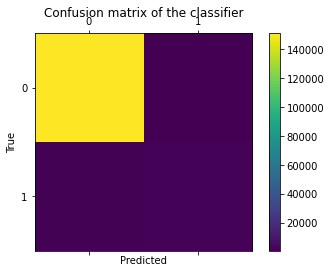

In [14]:
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix
model = LinearSVC(random_state=0, C=best[0], loss='squared_hinge', dual=True)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("LSVM-ACCURACY => "+str(metrics.accuracy_score(y_test, y_pred)*100)+str(" %"))

#CONFUSION MATRIX
print(confusion_matrix(y_test,y_pred))
print('\n')
print(classification_report(y_test,y_pred))

#Plot confusion_matrix
labels = ['0', '1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion_matrix(y_test,y_pred))
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
'''#NAIVE  BAYES
import time
start=time.time()
import sklearn.metrics as metrics
from sklearn.naive_bayes import GaussianNB
naive=GaussianNB()
naive.fit(X_train.todense(),y_train)
y_pred = naive.predict(X_test)
print("'NAIVE-BAYES-ACCURACY => "+str(metrics.accuracy_score(y_test, y_pred)*100)+str(" %"))
end=time.time()
print("Time=",end-start)

#CLASSIFICATION REPORT
from sklearn.metrics import classification_report,confusion_matrix
#CONFUSION MATRIX
print(confusion_matrix(y_test,y_pred))
print('\n')
print(classification_report(y_test,y_pred))'''

LOGISTIC-REGRESSION-ACCURACY => 98.47803104533031 %
time= 2.3887245655059814
[[151307     84]
 [  2277   1460]]


              precision    recall  f1-score   support

           0       0.99      1.00      0.99    151391
           1       0.95      0.39      0.55      3737

    accuracy                           0.98    155128
   macro avg       0.97      0.70      0.77    155128
weighted avg       0.98      0.98      0.98    155128



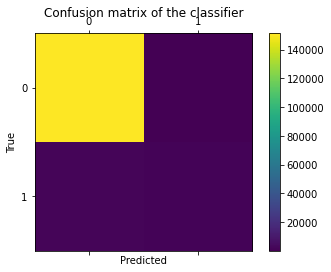

In [ ]:
#logistic regression
import time
start=time.time()
from sklearn import linear_model
from sklearn import metrics
log=linear_model.LogisticRegression()


log.fit(X_train,y_train)
y_pred=(log.predict(X_test))
print("LOGISTIC-REGRESSION-ACCURACY => "+str(metrics.accuracy_score(y_test, y_pred)*100)+str(" %"))
end=time.time()
print("time=",end-start)
#CLASSIFICATION REPORT
from sklearn.metrics import classification_report,confusion_matrix
#CONFUSION MATRIX
print(confusion_matrix(y_test,y_pred))
print('\n')
print(classification_report(y_test,y_pred))

#Plot confusion_matrix
labels = ['0', '1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion_matrix(y_test,y_pred))
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

MLP-ACCURACY => 98.52766747460163 %
time=196.18487906455994
[[150789    602]
 [  1682   2055]]


              precision    recall  f1-score   support

           0       0.99      1.00      0.99    151391
           1       0.77      0.55      0.64      3737

    accuracy                           0.99    155128
   macro avg       0.88      0.77      0.82    155128
weighted avg       0.98      0.99      0.98    155128



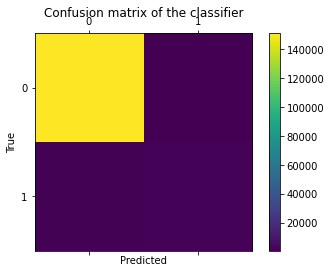

In [ ]:
#two hidden layers

import time
start=time.time()

from sklearn.neural_network import MLPClassifier
mlp= MLPClassifier(hidden_layer_sizes=(8,8), activation='relu', solver='adam',max_iter=200)
mlp.fit(X_train,y_train)
y_pred=(mlp.predict(X_test))
print("MLP-ACCURACY => "+str(metrics.accuracy_score(y_test, y_pred)*100)+str(" %"))
end=time.time()
print("time="+str(end-start))

#CLASSIFICATION REPORT
from sklearn.metrics import classification_report,confusion_matrix
#CONFUSION MATRIX
print(confusion_matrix(y_test,y_pred))
print('\n')
print(classification_report(y_test,y_pred))

#Plot confusion_matrix
labels = ['0', '1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion_matrix(y_test,y_pred))
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Adaboost-ACCURACY => 98.44708885565468 %
time=21.593843936920166
[[151043    348]
 [  2061   1676]]


              precision    recall  f1-score   support

           0       0.99      1.00      0.99    151391
           1       0.83      0.45      0.58      3737

    accuracy                           0.98    155128
   macro avg       0.91      0.72      0.79    155128
weighted avg       0.98      0.98      0.98    155128



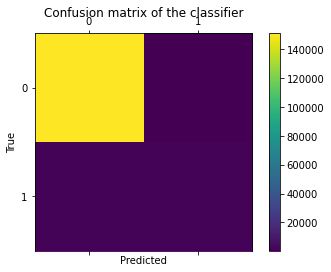

In [ ]:
import time
start=time.time()
from sklearn.ensemble import AdaBoostClassifier
abc = AdaBoostClassifier()

# Train Adaboost Classifer
model = abc.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Adaboost-ACCURACY => "+str(metrics.accuracy_score(y_test, y_pred)*100)+str(" %"))
end=time.time()
print("time="+str(end-start))


#CLASSIFICATION REPORT
from sklearn.metrics import classification_report,confusion_matrix
#CONFUSION MATRIX
print(confusion_matrix(y_test,y_pred))
print('\n')
print(classification_report(y_test,y_pred))

#Plot confusion_matrix
labels = ['0', '1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion_matrix(y_test,y_pred))
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


Confusion Matrix : model evaluation
[[149981   1410]
 [  2223   1514]]

 Classification report :
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    151391
           1       0.52      0.41      0.45      3737

    accuracy                           0.98    155128
   macro avg       0.75      0.70      0.72    155128
weighted avg       0.97      0.98      0.98    155128

Decision Tree-ACCURACY => 97.65806301892631 %


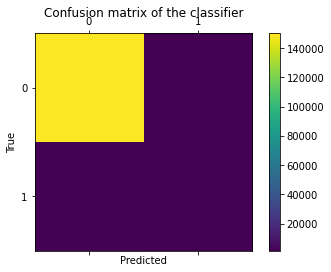

In [16]:
#DECISION TREE
import time
Start = time.time ()
from sklearn.tree import DecisionTreeClassifier 
Decision_tree= DecisionTreeClassifier(criterion = 'gini') 
Decision_tree.fit(X_train, y_train)
Y_pred = Decision_tree.predict(X_test) 
    
print("\nConfusion Matrix : model evaluation")
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, Y_pred))
    
print("\n Classification report :")
from sklearn.metrics import classification_report
print(classification_report(y_test, Y_pred))
    

from sklearn import metrics
print("Decision Tree-ACCURACY => "+str(metrics.accuracy_score(y_test, Y_pred)*100)+str(" %"))

#Plot confusion_matrix
labels = ['0', '1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion_matrix(y_test,Y_pred))
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
'''# Import necessary modules 
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn import metrics 
from sklearn.metrics import classification_report, confusion_matrix
# Load data 
data = pd. read_csv('diabetes.csv')
print(data.shape)
print ("sampe data")
print(data.head())
# Create feature and target arrays 
labels=data['Outcome']
features=data.drop(['Outcome'],axis=1)
print (list(features))
X=features.values
y=labels.values
# Split into training and test set 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33,random_state=10)
#Import SVM model
svclassifier = SVC(kernel='linear')
#Create a SVM Classifier
svclassifier.fit(X_train, y_train)
#Train the model using the training sets
y_pred = svclassifier.predict(X_test)
# Model Accuracy
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

#Model Evaluation: Compute classification_report and  confusion_matrix
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

#Plot confusion_matrix
labels = ['0', '1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion_matrix(y_test,y_pred))
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()'''